# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
import random as rd
import numpy as np
from PIL import Image
import cPickle as pkl
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy import misc
import helper_functions as hp

#### Generating Synthetic Dataset

In [ ]:
# unzip the mnist files available under MNIST_data folder
hp.unzip_mnist(dataset = "training", path="./MNIST_data/")
hp.unzip_mnist(dataset = "testing", path="./MNIST_data/")
train_images, train_labels = hp.load_mnist(dataset = "training", path="./MNIST_data/")
test_images, test_labels = hp.load_mnist(dataset = "testing", path="./MNIST_data/")

In [ ]:
print "the train images dataset has %d images with %d x %d dimensions" % train_images.shape
print "the test images dataset has %d images with %d x %d dimensions" % test_images.shape

In [ ]:
# TODO: check why it isnt working when path is given as a parameter
def generate_synthatic_dataset_from_mnist(images, labels, path,dataset = 'train'):
    path = os.getcwd()
    rd.seed(0)
    con_label_all = []
    con_image_all = []
    for name, image in enumerate(images):
        rand_size = rd.randint(1, 5)
        con_image = image
        con_label = [labels[name]]
        for i in range(rand_size-1):
            rand = rd.randint(0, images.shape[0] -1)
            con_image = np.concatenate((con_image,images[rand]),axis=1)
            con_label.append(labels[rand])
        zeros = np.zeros((28*(rand_size-1), 28*rand_size))
        con_image = np.concatenate((con_image,zeros),axis=0)
        con_label_all.append(con_label)
        con_image_all.append(con_image)
        im = Image.fromarray(np.uint8(con_image*255)).resize((54,54))
        im.save('./MNIST_data/' + dataset + '/' + str(name) + ".PNG")
    pkl.dump(con_label_all, open('./MNIST_data/'+dataset + "_labels.p","wb"))

In [ ]:
generate_synthatic_dataset_from_mnist(test_images, test_labels, './MNIST_data/test/', dataset='test')
generate_synthatic_dataset_from_mnist(train_images, train_labels, './MNIST_data/train/', dataset='train')

#### Read Generated Dataset

Now that I have all the synthea generated and 

In [ ]:
def prepare_data_for_tf(path,info):
    images_list = os.listdir(path)
    png = []
    labels = []
    for j, image in enumerate(images_list):
        read_image = misc.imread(path+image)
        image_np = np.asarray(read_image)        
        image_num = int(image[:-4])
        image_label = info[image_num] 
        image_length = len(info[image_num])
        if image_length >5:
            continue
        for i in range(image_length, 5):
            image_label = np.append(image_label,10)
        image_label = np.append(image_label,image_length)
        labels.append(image_label)
        png.append(image_np) 
    images = np.asarray(png,dtype=np.uint16)
    labels =  np.asarray(labels)
    return images, labels

In [ ]:
test_images_info = pkl.load(open('./MNIST_data/test_labels.p', "rb"))
test_image_real, test_label_real = prepare_data_for_tf('./MNIST_data/test/',test_images_info)

In [ ]:
train_images_info = pkl.load(open('./MNIST_data/train_labels.p', "rb"))
train_image_real, train_label_real = prepare_data_for_tf('./MNIST_data/train/',train_images_info)

In [ ]:
all_data_dict = {'train_images' : train_image_real,
                 'train_labels' : train_label_real,
                 'test_images': test_image_real,
                 'test_labels': test_label_real }

with open('./MNIST_data/train_test_data.p', 'wb') as handle:
    pkl.dump(all_data_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)

#### 

In [103]:
train_test_data = pkl.load(open('./MNIST_data/train_test_data.p', "rb"))

In [104]:
print train_test_data.keys()
train_label_real = train_test_data['train_labels']
test_label_real = train_test_data['test_labels']
train_image_real = train_test_data['train_images']
test_image_real = train_test_data['test_images']

['train_labels', 'test_labels', 'train_images', 'test_images']


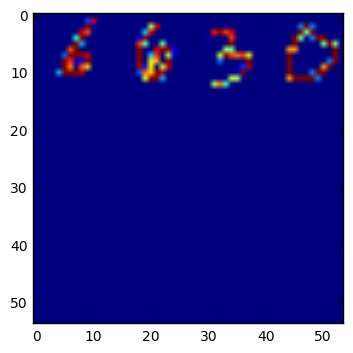

array([ 6,  6,  3,  0, 10,  4])

In [105]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.fromarray(np.uint8(train_image_real[500]))
plt.imshow(im)
plt.show()

train_label_real[500]

In [106]:
# Normalize images 
test_images = (test_image_real - float(128))/float(128)
train_images = (train_image_real[:20000] - float(128))/float(128)

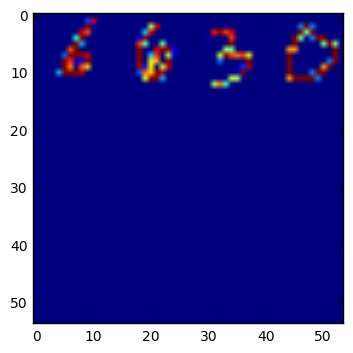

array([ 6,  6,  3,  0, 10,  4])

In [107]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.fromarray(np.uint8(train_images[500] * 128 +128))
plt.imshow(im)
plt.show()

train_label_real[500]

In [108]:
train_labels_enc = hp.one_hot_encode_labels(train_label_real[:20000])
test_labels_enc = hp.one_hot_encode_labels(test_label_real)

In [109]:
y1 = train_labels_enc[:,0,:]
y2 = train_labels_enc[:,1,:]
y3 = train_labels_enc[:,2,:]
y4 = train_labels_enc[:,3,:]
y5 = train_labels_enc[:,4,:]
y_seq_len = train_labels_enc[:,5,:]

y_labels = [y_seq_len, y1, y2, y3, y4, y5]

vy1 = test_labels_enc[:,0,:]
vy2 = test_labels_enc[:,1,:]
vy3 = test_labels_enc[:,2,:]
vy4 = test_labels_enc[:,3,:]
vy5 = test_labels_enc[:,4,:]
vy_seq_len = test_labels_enc[:,5,:] 

vx = test_images
validation_data = (vx, [vy_seq_len, vy1, vy2, vy3, vy4, vy5])

y_seq_len_trunc = y_seq_len[:,1:6]
vy_seq_len_trunc = vy_seq_len[:,1:6]

In [110]:
test_images = test_images.reshape(10000, 54,54,1)
train_images = train_images.reshape(20000, 54,54,1)

#### Model

In [111]:
import tensorflow as tf
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

# https://github.com/fchollet/keras/issues/4207
K.set_learning_phase(0)

img_len = 54
img_wid = 54
img_dep = 1
# this placeholder will contain our input digits, as flat vectors
inputs = tf.placeholder(tf.float32, shape=(None,img_len, img_wid, img_dep))

d1_ = tf.placeholder(tf.float32, shape=[None, 11])
d2_ = tf.placeholder(tf.float32, shape=[None, 11])
d3_ = tf.placeholder(tf.float32, shape=[None, 11])
d4_ = tf.placeholder(tf.float32, shape=[None, 11])
d5_ = tf.placeholder(tf.float32, shape=[None, 11])
d_len_ = tf.placeholder(tf.float32, shape=[None, 5])

In [112]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, Dropout, Activation, Flatten

x = Convolution2D(48, 5, 5, border_mode='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(64, 5, 5)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(128, 5, 5)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = tf.reshape(x, [-1, np.prod(x.get_shape()[1:].as_list())])
x = Dense(2048, activation="relu")(x)
x = Dropout(0.25)(x)

x = Dense(2048, activation="relu")(x)
x = Dropout(0.25)(x)

# Keras layers can be called on TensorFlow tensors:
d1 = Dense(11, init='normal', activation='softmax')(x)
d2 = Dense(11, init='normal', activation='softmax')(x)
d3 = Dense(11, init='normal', activation='softmax')(x)
d4 = Dense(11, init='normal', activation='softmax')(x)
d5 = Dense(11, init='normal', activation='softmax')(x)
d_len = Dense(5, init='normal', activation='softmax')(x)

In [113]:
sess.run(tf.global_variables_initializer())

loss = tf.nn.softmax_cross_entropy_with_logits(d_len, d_len_)
loss += tf.nn.softmax_cross_entropy_with_logits(d1, d1_)
loss += tf.nn.softmax_cross_entropy_with_logits(d2, d2_)
loss += tf.nn.softmax_cross_entropy_with_logits(d3, d3_)
loss += tf.nn.softmax_cross_entropy_with_logits(d4, d4_)
loss += tf.nn.softmax_cross_entropy_with_logits(d5, d5_)

In [114]:
def prepare_accuracy_placeholders(preds, labels):
    correct_prediction = tf.equal(tf.argmax(preds,1), tf.argmax(labels,1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cross_entropy = tf.reduce_mean(loss)
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
batch_size = 100
n_epoch = 3
test_size = 1000
with sess.as_default():
    for j in range(n_epoch):
        for i in range(199):
            batch = [train_images[i*batch_size:i*batch_size+batch_size], 
                     y_seq_len_trunc[i*batch_size:i*batch_size+batch_size], 
                     y1[i*batch_size:i*batch_size+batch_size],
                     y2[i*batch_size:i*batch_size+batch_size],
                     y3[i*batch_size:i*batch_size+batch_size],
                     y4[i*batch_size:i*batch_size+batch_size],
                     y5[i*batch_size:i*batch_size+batch_size]]
            train_step.run(feed_dict={inputs: batch[0], d_len_: batch[1], 
                                      d1_ : batch[2], d2_ : batch[3],
                                      d3_ : batch[4], d4_ : batch[5],d5_ : batch[6]})
            if i%25 == 0:
                print("Finished the %d iteration of epoch %d"% (i, j))
        ### Report predictions so far
        len_acc = prepare_accuracy_placeholders(d_len, d_len_)
        d1_acc = prepare_accuracy_placeholders(d1, d1_)
        d2_acc = prepare_accuracy_placeholders(d2, d2_)
        d3_acc = prepare_accuracy_placeholders(d3, d3_)
        d4_acc = prepare_accuracy_placeholders(d4, d4_)
        d5_acc = prepare_accuracy_placeholders(d5, d5_)

        feed_dict = {inputs: test_images[:test_size], d_len_: vy_seq_len_trunc[:test_size], 
                     d1_ : vy1[:test_size], d2_ : vy2[:test_size],
                     d3_ : vy3[:test_size], d4_ : vy4[:test_size] ,d5_ : vy5[:test_size]}
        print("sequence length accuracy is: %f" % len_acc.eval(feed_dict=feed_dict))
        print("digit 1 accuracy is: %f" % d1_acc.eval(feed_dict=feed_dict))
        print("digit 2 accuracy is: %f" % d2_acc.eval(feed_dict=feed_dict))
        print("digit 3 accuracy is: %f" % d3_acc.eval(feed_dict=feed_dict))
        print("digit 4 accuracy is: %f" % d4_acc.eval(feed_dict=feed_dict))
        print("digit 5 accuracy is: %f" % d5_acc.eval(feed_dict=feed_dict))

Finished the 0 iteration of epoch 0
Finished the 25 iteration of epoch 0
Finished the 50 iteration of epoch 0
Finished the 75 iteration of epoch 0
Finished the 100 iteration of epoch 0
Finished the 125 iteration of epoch 0
Finished the 150 iteration of epoch 0
Finished the 175 iteration of epoch 0
sequence length accuracy is: 0.358000
digit 1 accuracy is: 0.114000
digit 2 accuracy is: 0.191000
digit 3 accuracy is: 0.418000
digit 4 accuracy is: 0.618000
digit 5 accuracy is: 0.814000
Finished the 0 iteration of epoch 1
Finished the 25 iteration of epoch 1
Finished the 50 iteration of epoch 1
Finished the 75 iteration of epoch 1
Finished the 100 iteration of epoch 1
Finished the 125 iteration of epoch 1
Finished the 150 iteration of epoch 1
Finished the 175 iteration of epoch 1
sequence length accuracy is: 0.610000
digit 1 accuracy is: 0.171000
digit 2 accuracy is: 0.191000
digit 3 accuracy is: 0.418000
digit 4 accuracy is: 0.618000
digit 5 accuracy is: 0.814000
Finished the 0 iteration o

In [115]:
def compute_accuracy(array_preds, array_act):
    count = 0
    for j, length in enumerate(array_preds[0]):
        correct_pred = True
        for i in range(length+1):
            if array_act[i][j] != array_preds[i][j]:
                correct_pred = False
        if correct_pred:
            count += 1
    print count
    print len(array_preds[0])
    return float(count)/len(array_preds[0])

In [116]:
p_len = tf.argmax(d_len,1)
p1 =  tf.argmax(d1,1)
p2 =  tf.argmax(d2,1)
p3 =  tf.argmax(d3,1)
p4 =  tf.argmax(d4,1)
p5 =  tf.argmax(d5,1)

all_data_preds = tf.pack([p_len,p1,p2,p3,p4,p5])

p_len_ = tf.argmax(d_len_,1)
p1_ =  tf.argmax(d1_,1)
p2_ =  tf.argmax(d2_,1)
p3_ =  tf.argmax(d3_,1)
p4_ =  tf.argmax(d4_,1)
p5_ =  tf.argmax(d5_,1)

all_data_act = tf.pack([p_len_,p1_,p2_,p3_,p4_,p5_])
test_size = 1000
feed_dict = {inputs: test_images[:test_size], d_len_: vy_seq_len_trunc[:test_size], 
             d1_ : vy1[:test_size], d2_ : vy2[:test_size],
             d3_ : vy3[:test_size], d4_ : vy4[:test_size] ,d5_ : vy5[:test_size]}
with sess.as_default():
    all_data_preds_eval = all_data_preds.eval(feed_dict=feed_dict)
    all_data_act_eval = all_data_act.eval(feed_dict=feed_dict)

In [117]:
accuracy = compute_accuracy(all_data_preds_eval,all_data_act_eval)
print "The accuracy of our predictor is %f"% accuracy

231
1000
The accuracy of our predictor is 0.231000


In [118]:
print "Sequence length predicted then actual: "
print all_data_preds_eval[0][:20]
print all_data_act_eval[0][:20]
print "digit 1 predicted then actual: "
print all_data_preds_eval[1][:20]
print all_data_act_eval[1][:20]
print "digit 2 predicted then actual: "
print all_data_preds_eval[2][:20]
print all_data_act_eval[2][:20]
print "digit 3 predicted then actual: "
print all_data_preds_eval[3][:20]
print all_data_act_eval[3][:20]
print "digit 4 predicted then actual: "
print all_data_preds_eval[4][:20]
print all_data_act_eval[4][:20]
print "digit 5 predicted then actual: "
print all_data_preds_eval[5][:20]
print all_data_act_eval[5][:20]

Sequence length predicted then actual: 
[0 2 1 0 2 0 3 2 3 1 2 2 3 3 3 0 2 0 3 0]
[0 2 1 0 2 0 4 2 4 1 2 2 4 3 4 0 2 0 3 0]
digit 1 predicted then actual: 
[7 1 0 7 1 0 1 0 1 0 1 0 1 1 1 6 1 6 1 1]
[7 9 7 9 0 3 9 0 1 7 4 4 0 9 1 8 2 4 2 1]
digit 2 predicted then actual: 
[10  2  8 10  2 10  1  2  1  1  2  2  1  1  1 10  2 10  1 10]
[10  7  8 10  3 10  1  2  4  8  9  4  5  7  0 10  0 10  4 10]
digit 3 predicted then actual: 
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[10  6 10 10  4 10  9  5  0 10  3  8  9  7  4 10  6 10  3 10]
digit 4 predicted then actual: 
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[10 10 10 10 10 10  8 10  3 10 10 10  5  5  4 10 10 10  8 10]
digit 5 predicted then actual: 
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[10 10 10 10 10 10  0 10  1 10 10 10  2 10  9 10 10 10 10 10]


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

For this problem I started by reading the Goodfellow paper on this particular problem. From there I decided to use convolution layers and then fully connected layers to solve this problem. To understand the problem better I consulted the forums often to find answers to common problems I shared with other students.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

My model is an edited version of Goodfellow where it is made up of a series of convolution layers and connected to 2 fully connected layers at the end. In particular, it is build as follows:

* Convolution(48) --> maxpooling --> Dropout --> Relu
* Convolution(64) --> maxpooling --> Dropout --> Relu
* Convolution(128) --> maxpooling --> Dropout --> Relu
* Flatten()
* Fully connected(2084) --> Relu
* Fully connected(2084) --> Relu

Then for each digit seperate there is a fully connected layer with softmax
* digit1: Fully connected(11) --> Softmax
* digit2: Fully connected(11) --> Softmax
* digit3: Fully connected(11) --> Softmax
* digit4: Fully connected(11) --> Softmax
* digit5: Fully connected(11) --> Softmax
* sequence length : Fully connected(5) --> Softmax

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

** How did you train your model? **
The model was trained by reducing the loss from each digit and digit length altogether using stochastic gradient descent with a learning rate of 0.01


** How did you generate your synthetic dataset? ** To generate the dataset I followed the following approach:
* for each image in the MNIST dataset, generate a random number between 1 and 5 which will be used as the sequence length
* Append images randomly from the dataset of the current image until I match the sequnce length generated
* Resize the image produced to 54 x 54 size
* Example of the images produced are found in the code blocks above

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Preparing the data

In [ ]:
hp.untar_svhn(dataset = "training", path="./SVHN_data/")
hp.untar_svhn(dataset = "testing", path="./SVHN_data/")

In [ ]:
test_images_info = hp.read_process_h5('./SVHN_data/test/digitStruct.mat')
print test_images_info[2]

In [ ]:
train_images_info = hp.read_process_h5('./SVHN_data/train/digitStruct.mat')
print train_images_info[2]

In [ ]:
hp.process_all_images('./SVHN_data/test/','./SVHN_data/test_proc/',test_images_info)

In [ ]:
hp.process_all_images('./SVHN_data/train/','./SVHN_data/train_proc/',train_images_info)

In [ ]:
def prepare_svhn_data_for_tf(path,info):
    images_list = os.listdir(path)
    png = []
    labels = []
    for image in images_list:
        read_image = misc.imread(path+image)
        image_np = np.asarray(read_image)
        image_np = np.concatenate(np.concatenate(image_np))
        png.append(image_np)   
        
        image_num = int(image[:-4]) - 1
        image_label = info[image_num]['labels']
        image_length = info[image_num]['length']
        if image_length >5:
            image_label = image_label[:5]
        for i in range(image_length, 5):
            image_label = np.append(image_label,0)
        image_label = np.append(image_label,image_length)
        labels.append(image_label)
        
    images = np.asarray(png,dtype=np.uint16)
    labels =  np.asarray(labels)
    return images, labels

In [ ]:
test_image_real, test_label_real = prepare_svhn_data_for_tf('./SVHN_data/test_proc/',test_images_info)

In [ ]:
train_image_real, train_label_real = prepare_svhn_data_for_tf('./SVHN_data/train_proc/',train_images_info)

In [ ]:
all_data_dict = {'train_images' : train_image_real,
                 'train_labels' : train_label_real,
                 'test_images': test_image_real,
                 'test_labels': test_label_real }

with open('./SVHN_data/train_test_data.p', 'wb') as handle:
    pkl.dump(all_data_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)

#### Reading the generated data

In [119]:
train_test_data = pkl.load(open('./SVHN_data/train_test_data.p', "rb"))

In [120]:
print train_test_data.keys()
train_label_real = train_test_data['train_labels']
test_label_real = train_test_data['test_labels']
train_image_real = train_test_data['train_images']
test_image_real = train_test_data['test_images']
print train_image_real.shape

['train_labels', 'test_labels', 'train_images', 'test_images']
(33402, 8748)


In [4]:
train_image_real = train_image_real.reshape(len(train_image_real), 54,54,3)
test_image_real = test_image_real.reshape(len(test_image_real), 54,54,3)

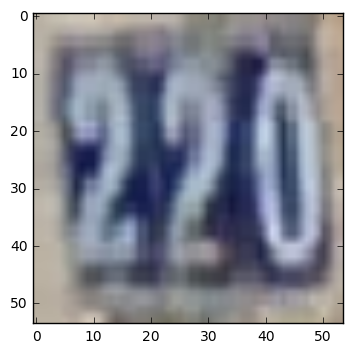

array([  2.,   2.,  10.,   0.,   0.,   3.])

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.fromarray(np.uint8(train_image_real[500]))
plt.imshow(im)
plt.show()

train_label_real[500]

In [7]:
# Normalize images 
test_images = (test_image_real - float(128))/float(128)
train_images_1 = (train_image_real[:5000] - float(128))/float(128)
train_images_2 = (train_image_real[5000:10000] - float(128))/float(128)
train_images_3 = (train_image_real[10000:15000] - float(128))/float(128)
train_images_4 = (train_image_real[15000:20000] - float(128))/float(128)
train_images = np.concatenate([train_images_1,train_images_2, train_images_3, train_images_4], axis=0)
print train_images.shape

(20000, 54, 54, 3)


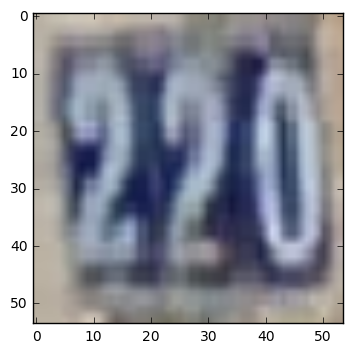

array([  2.,   2.,  10.,   0.,   0.,   3.])

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.fromarray(np.uint8(train_images[500] * 128 +128))
plt.imshow(im)
plt.show()

train_label_real[500]

In [10]:
train_labels_enc = hp.one_hot_encode_labels(train_label_real[:20000])
test_labels_enc = hp.one_hot_encode_labels(test_label_real)

In [11]:
y1 = train_labels_enc[:,0,:]
y2 = train_labels_enc[:,1,:]
y3 = train_labels_enc[:,2,:]
y4 = train_labels_enc[:,3,:]
y5 = train_labels_enc[:,4,:]
y_seq_len = train_labels_enc[:,5,:]

y_labels = [y_seq_len, y1, y2, y3, y4, y5]

vy1 = test_labels_enc[:,0,:]
vy2 = test_labels_enc[:,1,:]
vy3 = test_labels_enc[:,2,:]
vy4 = test_labels_enc[:,3,:]
vy5 = test_labels_enc[:,4,:]
vy_seq_len = test_labels_enc[:,5,:] 

vx = test_images
validation_data = (vx, [vy_seq_len, vy1, vy2, vy3, vy4, vy5])

y_seq_len_trunc = y_seq_len[:,1:6]
vy_seq_len_trunc = vy_seq_len[:,1:6]

#### Model

In [12]:
import tensorflow as tf
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

# https://github.com/fchollet/keras/issues/4207
K.set_learning_phase(0)

img_len = 54
img_wid = 54
img_dep = 3
# this placeholder will contain our input digits, as flat vectors
inputs = tf.placeholder(tf.float32, shape=(None,img_len, img_wid, img_dep))

d1_ = tf.placeholder(tf.float32, shape=[None, 11])
d2_ = tf.placeholder(tf.float32, shape=[None, 11])
d3_ = tf.placeholder(tf.float32, shape=[None, 11])
d4_ = tf.placeholder(tf.float32, shape=[None, 11])
d5_ = tf.placeholder(tf.float32, shape=[None, 11])
d_len_ = tf.placeholder(tf.float32, shape=[None, 5])

Using TensorFlow backend.


In [13]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, Dropout, Activation, Flatten

x = Convolution2D(48, 5, 5, border_mode='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(64, 5, 5)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(128, 5, 5)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = tf.reshape(x, [-1, np.prod(x.get_shape()[1:].as_list())])
x = Dense(2048, activation="relu")(x)
x = Dropout(0.25)(x)

x = Dense(2048, activation="relu")(x)
x = Dropout(0.25)(x)

# Keras layers can be called on TensorFlow tensors:
d1 = Dense(11, init='normal', activation='softmax')(x)
d2 = Dense(11, init='normal', activation='softmax')(x)
d3 = Dense(11, init='normal', activation='softmax')(x)
d4 = Dense(11, init='normal', activation='softmax')(x)
d5 = Dense(11, init='normal', activation='softmax')(x)
d_len = Dense(5, init='normal', activation='softmax')(x)

In [14]:
sess.run(tf.global_variables_initializer())

loss = tf.nn.softmax_cross_entropy_with_logits(d_len, d_len_)
loss += tf.nn.softmax_cross_entropy_with_logits(d1, d1_)
loss += tf.nn.softmax_cross_entropy_with_logits(d2, d2_)
loss += tf.nn.softmax_cross_entropy_with_logits(d3, d3_)
loss += tf.nn.softmax_cross_entropy_with_logits(d4, d4_)
loss += tf.nn.softmax_cross_entropy_with_logits(d5, d5_)

In [15]:
def prepare_accuracy_placeholders(preds, labels):
    correct_prediction = tf.equal(tf.argmax(preds,1), tf.argmax(labels,1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cross_entropy = tf.reduce_mean(loss)
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
batch_size = 100
n_epoch = 3
test_size = 1000
with sess.as_default():
    for j in range(n_epoch):
        for i in range(199):
            batch = [train_images[i*batch_size:i*batch_size+batch_size], 
                     y_seq_len_trunc[i*batch_size:i*batch_size+batch_size], 
                     y1[i*batch_size:i*batch_size+batch_size],
                     y2[i*batch_size:i*batch_size+batch_size],
                     y3[i*batch_size:i*batch_size+batch_size],
                     y4[i*batch_size:i*batch_size+batch_size],
                     y5[i*batch_size:i*batch_size+batch_size]]
            train_step.run(feed_dict={inputs: batch[0], d_len_: batch[1], 
                                      d1_ : batch[2], d2_ : batch[3],
                                      d3_ : batch[4], d4_ : batch[5],d5_ : batch[6]})
            if i%25 == 0:
                print("Finished the %d iteration of epoch %d"% (i, j))
        ### Report predictions so far
        len_acc = prepare_accuracy_placeholders(d_len, d_len_)
        d1_acc = prepare_accuracy_placeholders(d1, d1_)
        d2_acc = prepare_accuracy_placeholders(d2, d2_)
        d3_acc = prepare_accuracy_placeholders(d3, d3_)
        d4_acc = prepare_accuracy_placeholders(d4, d4_)
        d5_acc = prepare_accuracy_placeholders(d5, d5_)

        feed_dict = {inputs: test_images[:test_size], d_len_: vy_seq_len_trunc[:test_size], 
                     d1_ : vy1[:test_size], d2_ : vy2[:test_size],
                     d3_ : vy3[:test_size], d4_ : vy4[:test_size] ,d5_ : vy5[:test_size]}
        print("sequence length accuracy is: %f" % len_acc.eval(feed_dict=feed_dict))
        print("digit 1 accuracy is: %f" % d1_acc.eval(feed_dict=feed_dict))
        print("digit 2 accuracy is: %f" % d2_acc.eval(feed_dict=feed_dict))
        print("digit 3 accuracy is: %f" % d3_acc.eval(feed_dict=feed_dict))
        print("digit 4 accuracy is: %f" % d4_acc.eval(feed_dict=feed_dict))
        print("digit 5 accuracy is: %f" % d5_acc.eval(feed_dict=feed_dict))

Finished the 0 iteration of epoch 0
Finished the 25 iteration of epoch 0
Finished the 50 iteration of epoch 0
Finished the 75 iteration of epoch 0
Finished the 100 iteration of epoch 0
Finished the 125 iteration of epoch 0
Finished the 150 iteration of epoch 0
Finished the 175 iteration of epoch 0
sequence length accuracy is: 0.643000
digit 1 accuracy is: 0.283000
digit 2 accuracy is: 0.181000
digit 3 accuracy is: 0.824000
digit 4 accuracy is: 0.984000
digit 5 accuracy is: 1.000000
Finished the 0 iteration of epoch 1
Finished the 25 iteration of epoch 1
Finished the 50 iteration of epoch 1
Finished the 75 iteration of epoch 1
Finished the 100 iteration of epoch 1
Finished the 125 iteration of epoch 1
Finished the 150 iteration of epoch 1
Finished the 175 iteration of epoch 1
sequence length accuracy is: 0.643000
digit 1 accuracy is: 0.283000
digit 2 accuracy is: 0.181000
digit 3 accuracy is: 0.824000
digit 4 accuracy is: 0.984000
digit 5 accuracy is: 1.000000
Finished the 0 iteration o

In [16]:
p_len = tf.argmax(d_len,1)
p1 =  tf.argmax(d1,1)
p2 =  tf.argmax(d2,1)
p3 =  tf.argmax(d3,1)
p4 =  tf.argmax(d4,1)
p5 =  tf.argmax(d5,1)

all_data_preds = tf.pack([p_len,p1,p2,p3,p4,p5])

p_len_ = tf.argmax(d_len_,1)
p1_ =  tf.argmax(d1_,1)
p2_ =  tf.argmax(d2_,1)
p3_ =  tf.argmax(d3_,1)
p4_ =  tf.argmax(d4_,1)
p5_ =  tf.argmax(d5_,1)

all_data_act = tf.pack([p_len_,p1_,p2_,p3_,p4_,p5_])
test_size = 1000
feed_dict = {inputs: test_images[:test_size], d_len_: vy_seq_len_trunc[:test_size], 
             d1_ : vy1[:test_size], d2_ : vy2[:test_size],
             d3_ : vy3[:test_size], d4_ : vy4[:test_size] ,d5_ : vy5[:test_size]}
with sess.as_default():
    all_data_preds_eval = all_data_preds.eval(feed_dict=feed_dict)
    all_data_act_eval = all_data_act.eval(feed_dict=feed_dict)

In [19]:
accuracy = compute_accuracy(all_data_preds_eval,all_data_act_eval)
print "The accuracy of our predictor is %f"% accuracy

160
1000
The accuracy of our predictor is 0.160000


In [27]:
print "Sequence length predicted then actual: "
print all_data_preds_eval[0][:20]
print all_data_act_eval[0][:20]
print "digit 1 predicted then actual: "
print all_data_preds_eval[1][:20]
print all_data_act_eval[1][:20]
print "digit 2 predicted then actual: "
print all_data_preds_eval[2][:20]
print all_data_act_eval[2][:20]
print "digit 3 predicted then actual: "
print all_data_preds_eval[3][:20]
print all_data_act_eval[3][:20]
print "digit 4 predicted then actual: "
print all_data_preds_eval[4][:20]
print all_data_act_eval[4][:20]
print "digit 5 predicted then actual: "
print all_data_preds_eval[5][:20]
print all_data_act_eval[5][:20]

Sequence length predicted then actual: 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 0 2 1 1]
digit 1 predicted then actual: 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[3 4 4 2 1 9 1 2 6 3 1 4 8 5 5 2 2 3 8 5]
digit 2 predicted then actual: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 8  9 10  4  9  8  9  2  6  6  6 10  2 10  7  4  0  1  4  7]
digit 3 predicted then actual: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0 10  0  0]
digit 4 predicted then actual: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
digit 5 predicted then actual: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


1

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

I used the same architecture on the realistic dataset that I used with the synthetic data set as an initial attempt. The model did not produce good results with an accuracy of 16%

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

I tried to enhance the results by reducing the learning rate. This did not improve the results however. It only made it slower to converge to the "bad" results.
I also tried to reduce the complexity of the model but it did not help in improving the results.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

My model is not producing good results even with synthetic dataset. It only predicts length with high accuracy. So on the realistic dataset in especially it did not predict good results. Most of the times it is predicting one value for all the entries.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

(214, 266, 4)


In [49]:
from PIL import Image
first_image = Image.open('./captured_images/pic_14.png').convert('RGB')
resized = first_image.resize((54, 54))
resized.save('./captured_images/pic_14_resized.png')
second_image = Image.open('./captured_images/pic_165.png').convert('RGB')
resized = second_image.resize((54, 54))
resized.save('./captured_images/pic_165_resized.png')

In [52]:
from scipy import misc
first_image_resized = misc.imread("./captured_images/pic_14_resized.png")
second_image_resized = misc.imread("./captured_images/pic_165_resized.png")
print first_image_resized.shape
print second_image_resized.shape

(54, 54, 3)
(54, 54, 3)


In [98]:
first_image_label = np.asarray([1, 4, 0, 0, 0, 2])
enc = hp.one_hot_encode_labels(first_image_label)
first_image_label_enc =  np.concatenate((enc,np.zeros((6, 6))), axis=1)
print first_image_label_enc.shape
second_image_label = np.asarray([1, 6, 5, 0, 0, 3])
enc = hp.one_hot_encode_labels(second_image_label)
second_image_label_enc =  np.concatenate((enc,np.zeros((6, 4))), axis=1)
print second_image_label_enc.shape

(6, 11)
(6, 11)


In [99]:
captured_images = np.asarray([first_image_resized, second_image_resized])
captured_labels = np.asarray([first_image_label_enc,second_image_label_enc])

In [100]:
c1 = captured_labels[:,0,:]
c2 = captured_labels[:,1,:]
c3 = captured_labels[:,2,:]
c4 = captured_labels[:,3,:]
c5 = captured_labels[:,4,:]
c_seq_len = captured_labels[:,5,:]

c_seq_len_trunc = c_seq_len[:,1:6]

In [101]:
p_len = tf.argmax(d_len,1)
p1 =  tf.argmax(d1,1)
p2 =  tf.argmax(d2,1)
p3 =  tf.argmax(d3,1)
p4 =  tf.argmax(d4,1)
p5 =  tf.argmax(d5,1)

all_data_preds = tf.pack([p_len,p1,p2,p3,p4,p5])

p_len_ = tf.argmax(d_len_,1)
p1_ =  tf.argmax(d1_,1)
p2_ =  tf.argmax(d2_,1)
p3_ =  tf.argmax(d3_,1)
p4_ =  tf.argmax(d4_,1)
p5_ =  tf.argmax(d5_,1)

all_data_act = tf.pack([p_len_,p1_,p2_,p3_,p4_,p5_])

cap_dict = {inputs: captured_images, d_len_: c_seq_len_trunc, 
             d1_ : c1, d2_ : c2,
             d3_ : c3, d4_ : c4 ,d5_ : c5}
with sess.as_default():
    all_data_preds_eval = all_data_preds.eval(feed_dict=cap_dict)
    all_data_act_eval = all_data_act.eval(feed_dict=cap_dict)

In [102]:
print "Sequence length predicted then actual: "
print all_data_preds_eval[0][:20]
print all_data_act_eval[0][:20]
print "digit 1 predicted then actual: "
print all_data_preds_eval[1][:20]
print all_data_act_eval[1][:20]
print "digit 2 predicted then actual: "
print all_data_preds_eval[2][:20]
print all_data_act_eval[2][:20]
print "digit 3 predicted then actual: "
print all_data_preds_eval[3][:20]
print all_data_act_eval[3][:20]
print "digit 4 predicted then actual: "
print all_data_preds_eval[4][:20]
print all_data_act_eval[4][:20]
print "digit 5 predicted then actual: "
print all_data_preds_eval[5][:20]
print all_data_act_eval[5][:20]

Sequence length predicted then actual: 
[1 1]
[1 2]
digit 1 predicted then actual: 
[1 1]
[1 1]
digit 2 predicted then actual: 
[0 0]
[4 6]
digit 3 predicted then actual: 
[0 0]
[0 5]
digit 4 predicted then actual: 
[0 0]
[0 0]
digit 5 predicted then actual: 
[0 0]
[0 0]


### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

I chose only 2 images just to illustrate the idea of testing on my own images.

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

The model did not predict the results correctly as reported above because the model has a very low accuracy.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.